### Setup

In [1]:
# import
import tensorflow as tf

print(tf.__version__)

2.15.0


In [2]:
# To generate GIFs
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [3]:
! pip install tensorflow-addons

In [4]:
# import
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
# get data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
#rescale
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
# display shape
train_images.shape, type(train_images)

((60000, 28, 28, 1), numpy.ndarray)

In [8]:
# labels
train_labels.shape, type(train_labels), np.unique(train_labels)

((60000,), numpy.ndarray, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

This is the information you need to verify if you use your own dataset.

In [9]:
# args
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [10]:
60000 / 32

1875.0

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# train_dataset
train_dataset, type(train_dataset)

(<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>,
 tensorflow.python.data.ops.batch_op._BatchDataset)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

#### Generator with Attention

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

### Hide it

In [15]:
def make_generator_model():
    # Input layer
    inputs = layers.Input(shape=(784,))

    # Dense layer for initial processing
    x = layers.Dense(7*7*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Reshape to fit for multi-head attention
    x = layers.Reshape((49, 256))(x)  # 7*7 = 49

    # MultiHead Attention layer
    # Since 'query', 'key', and 'value' can be the same tensor for self-attention,
    # we pass 'x' three times to the layer.
    attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x, x)
    attention_output = layers.LeakyReLU()(attention_output)

    # Combine attention output with the original sequence
    # Optionally, you might want to combine or process the attention output further
    # before moving on to the next layers; a simple way is to concatenate.
    x = layers.Concatenate(axis=-1)([x, attention_output])

    # Proceed with the model as before
    x = layers.Flatten()(x)
    x = layers.Reshape((7, 7, 512))(x)  # Adjusted due to concatenation

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=x)

    return model


### Draft Vapad Code

In [56]:
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers


class VapadModel:
    def __init__(
        self,
        num_classes: int = 2,  # Number of output classes
        input_shape: Tuple[int, int, int] = (299, 299, 3),  # Shape of input images
        learning_rate: float = 0.001,  # Learning rate for the optimizer
        weight_decay: float = 0.0001,  # Weight decay for regularization
        batch_size: int = 256,  # Batch size for training
        num_epochs: int = 800,  # Number of epochs for training
        image_size: int = 72,  # Size to resize images to after augmentation
        patch_size: int = 6,  # Size of the patches to extract from images
        projection_dim: int = 64,  # Dimensionality of the projection space
        num_heads: int = 4,  # Number of attention heads
        transformer_units: List[int] = [128, 64],  # Sizes of the transformer layers
        transformer_layers: int = 10,  # Number of transformer layers
        mlp_head_units: List[int] = [2048, 1024],  # Sizes of the dense layers in the final classifier
    ) -> None:
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.image_size = image_size
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.transformer_layers = transformer_layers
        self.mlp_head_units = mlp_head_units
        self.num_patches = (image_size // patch_size) ** 2  # Compute the number of patches
        self.data_augmentation = keras.Sequential(  # Define the data augmentation pipeline
            [
                layers.Normalization(),
                layers.Resizing(image_size, image_size),
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(factor=0.02),
                layers.RandomZoom(height_factor=0.2, width_factor=0.2),
            ],
            name="data_augmentation",
        )
        self.encoder = self.create_encoder()  # Create the encoder model
        self.decoder = self.create_decoder()  # Create the decoder model

    class Patches(layers.Layer):  # Custom layer for extracting patches from images
        def __init__(self, patch_size: int) -> None:
            super().__init__()
            self.patch_size = patch_size  # Size of the patches

        def call(self, images: tf.Tensor) -> tf.Tensor:
            batch_size = tf.shape(images)[0]  # Get the batch size
            # Extract patches from images
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding="VALID",
            )
            patch_dims = patches.shape[-1]  # Get the dimensionality of the patches
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Reshape patches for processing
            return patches

    class PatchEncoder(layers.Layer):  # Custom layer for encoding patches
        def __init__(self, num_patches: int, projection_dim: int) -> None:
            super().__init__()
            self.num_patches = num_patches  # Number of patches
            self.projection = layers.Dense(units=projection_dim)  # Dense layer for projection
            self.position_embedding = layers.Embedding(  # Positional embedding layer
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patch: tf.Tensor) -> tf.Tensor:
            positions = tf.range(start=0, limit=self.num_patches, delta=1)  # Compute position indices
            encoded = self.projection(patch) + self.position_embedding(positions)  # Add position embeddings
            return encoded

    def mlp(self, x: tf.Tensor, hidden_units: List[int], dropout_rate: float) -> tf.Tensor:
        for units in hidden_units:  # Iterate over the sizes of the hidden units
            x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Apply Dense layer with GELU activation
            x = layers.Dropout(dropout_rate)(x)  # Apply dropout
        return x

    def create_encoder(self) -> keras.Model:  # Method to create the encoder model
        inputs = layers.Input(shape=self.input_shape)  # Input layer
        augmented = self.data_augmentation(inputs)  # Apply data augmentation
        patches = self.Patches(self.patch_size)(augmented)  # Extract patches
        encoded_patches = self.PatchEncoder(self.num_patches, self.projection_dim)(  # Encode patches
            patches
        )

        for _ in range(self.transformer_layers):  # Apply transformer layers
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            attention_output = layers.MultiHeadAttention(
                num_heads=self.num_heads, key_dim=self.projection_dim, dropout=0.1
            )(x1, x1)
            x2 = layers.Add()([attention_output, encoded_patches])
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            x3 = self.mlp(x3, hidden_units=self.transformer_units, dropout_rate=0.1)
            encoded_patches = layers.Add()([x3, x2])

        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  # Apply final layer normalization
        representation = layers.Flatten()(representation)  # Flatten the representation
        representation = layers.Dropout(0.5)(representation)  # Apply dropout
        features = self.mlp(  # Apply MLP to the flattened representation
            representation, hidden_units=self.mlp_head_units, dropout_rate=0.5
        )
        logits = layers.Dense(self.num_classes)(features)  # Output layer
        model = keras.Model(inputs=inputs, outputs=logits)  # Create the model
        return model

    def create_decoder(self) -> keras.Model:  # Method to create the decoder model
        decoder_inputs = layers.Input(shape=self.num_classes)  # Define the input layer

        # Start of neural network body
        x = layers.Dense(7*7*256, use_bias=False)(decoder_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Reshape to fit for multi-head attention
        x = layers.Reshape((49, 256))(x)  # 7*7 = 49

        # MultiHead Attention layer
        # Since 'query', 'key', and 'value' can be the same tensor for self-attention,
        # we pass 'x' three times to the layer.
        attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x, x)
        attention_output = layers.LeakyReLU()(attention_output)

        # Combine attention output with the original sequence
        # Optionally, you might want to combine or process the attention output further
        # before moving on to the next layers; a simple way is to concatenate.
        x = layers.Concatenate(axis=-1)([x, attention_output])

        # Proceed with the model as before
        x = layers.Flatten()(x)
        x = layers.Reshape((7, 7, 512))(x)  # Adjusted due to concatenation

        x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

        # Model
        model = keras.Model(inputs=decoder_inputs, outputs=x)  # Create the model

        return model

    def build_vapad_model(self) -> keras.Model:
        encoded_features = self.encoder.output  # Get encoder output
        decoded_output = self.decoder(encoded_features)  # Get decoder output
        model = keras.Model(inputs=self.encoder.input, outputs=decoded_output)  # Create the complete model

        return model

# Example usage:
# vapad_model = VapadModel(input_shape=(28, 28, 1))
# vapad_model.build_vapad_model().summary()


### Import from script

In [15]:
from vapad import *

In [16]:
# Example usage:
vapad_model = VapadModel(input_shape=(28, 28, 1))
# vapad_model.build_vapad_model().summary()

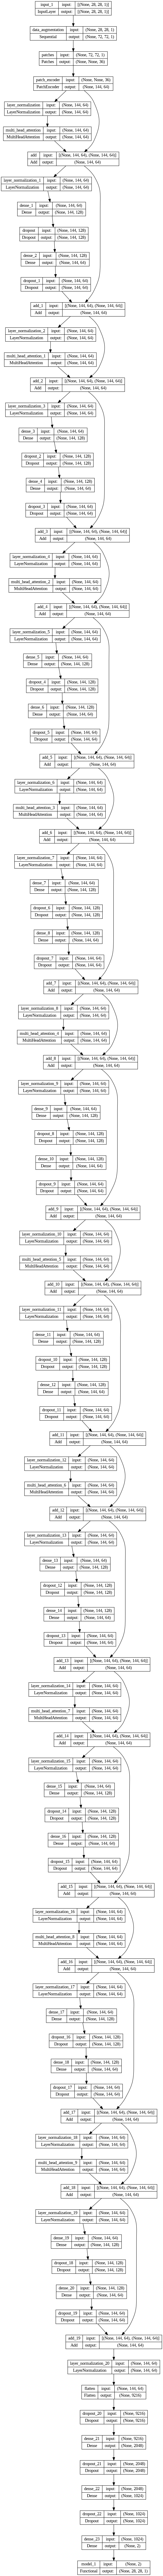

In [17]:
tf.keras.utils.plot_model(vapad_model.build_vapad_model(), show_shapes=True)

Use the (as yet untrained) generator to create an image.

(1, 28, 28, 1)
(1, 28, 28, 1)


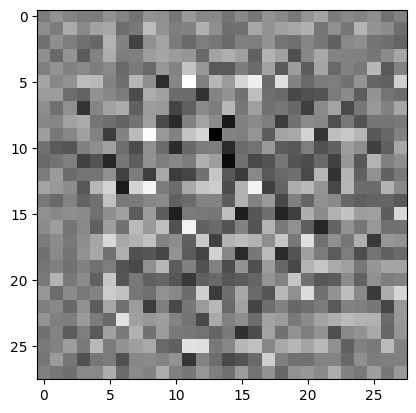

In [18]:
# create generator model
vapad_model = VapadModel(input_shape=(28, 28, 1))
generator = vapad_model.build_vapad_model()

# create noise and throw noise into the generator
# noise = tf.random.normal([1, 784])
noise = tf.random.normal([1, 28, 28, 1])
print(noise.shape)
generated_image = generator(noise)
print(generated_image.shape)

# plot an output from generator that is untrained
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier. Notice that in the beginning of the `make_discriminator_model()` function below the input_shape must be the same as the output shape of the generator.

In [19]:
# define discriminator model
def make_discriminator_model():

    # use sequential API
    model = tf.keras.Sequential()

    # add Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # add Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # flatten and output 1 neuron
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [20]:
def make_discriminator_model(input_shape=(28, 28, 1), num_blocks=4, num_heads=8, ff_dim=512, dropout_rate=0.1):

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # First, let's add a few convolutional layers for initial feature extraction
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # Transformer Encoder Blocks
    for _ in range(num_blocks):
        # Multi-Head Self-Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        # Residual Connection and Layer Normalization
        attention_output = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Feed Forward Network
        ffn_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(attention_output)
        ffn_output = layers.Conv1D(filters=x.shape[-1], kernel_size=1)(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        # Residual Connection and Layer Normalization
        x = layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [21]:
# define discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-2.515872]], shape=(1, 1), dtype=float32)


## How does VAPAD learn?

Let's enhance the sophistication and clarity of the mathematical exposition on how the VAPAD (Vision Augmented Prediction with Attention Design) learns through its training process.

Consider the framework where the discriminator, denoted as $D(x; \boldsymbol{\theta}_d)$, evaluates noisy data instances $x$ drawn from a prior distribution $p_z(z)$. Concurrently, the generator, symbolized as $G(z; \boldsymbol{\theta}_g)$, is devised. The objective for $D$ is to augment the probability of accurately assigning labels to both actual training data and synthetic instances produced by $G$. In parallel, $G$ endeavors to minimize $\log(1 - D(G(z)))$.

The interplay between $D$ and $G$ manifests as a dual-layer minimax contest characterized by the objective function $\mathcal{V}(G, D)$, formally expressed as:
$$ \min_{G} \max_{D} \mathcal{V}(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))] $$

Within each iteration of learning, the discriminator's gradient, with respect to its parameters $\boldsymbol{\theta}_d$, is updated as follows:
$$ \nabla_{\boldsymbol{\theta}_d} \frac{1}{m} \sum_{i=1}^m [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))] $$
where $m$ represents the number of samples under consideration.

Conversely, the gradient update for the generator, in relation to its parameters $\boldsymbol{\theta}_g$, is delineated by:
$$ \nabla_{\boldsymbol{\theta}_g} \frac{1}{m} \sum_{i=1}^m \log(1 - D(G(z^{(i)}))) $$
wherein $m$ similarly denotes the sample count, and the gradient is specifically with respect to $\boldsymbol{\theta}_g$.

This refined articulation not only underscores the mathematical elegance of the learning dynamics in GANs but also elucidates the sophisticated interdependence between the generator and discriminator within the adversarial framework.

In the context of Stochastic Gradient Descent (SGD) within a `VAPAD` framework, the optimization process involves iteratively adjusting the parameters of both the generator and the discriminator to minimize their respective loss functions. The SGD algorithm facilitates this by computing the gradients of the loss functions with respect to the model parameters and updating these parameters in the direction that reduces the loss. Here's how it unfolds, step by step, using mathematical notation:

### Step $s$: Gradient Computation

At each step $s$, the process begins with the computation of gradients for both the generator's loss ($\mathcal{L}_{\text{gen}}$) and the discriminator's loss ($\mathcal{L}_{\text{disc}}$) with respect to their parameters ($\boldsymbol{\theta}_g$ for the generator and $\boldsymbol{\theta}_d$ for the discriminator).

For the discriminator, the gradient of its loss with respect to its parameters is given by:
$$ \nabla_{\boldsymbol{\theta}_d}\mathcal{L}_{\text{disc}} = \nabla_{\boldsymbol{\theta}_d} \left( -\frac{1}{m} \sum_{i=1}^m [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))] \right) $$

And for the generator, the gradient of its loss with respect to its parameters is:
$$ \nabla_{\boldsymbol{\theta}_g}\mathcal{L}_{\text{gen}} = \nabla_{\boldsymbol{\theta}_g} \left( -\frac{1}{m} \sum_{i=1}^m \log(1 - D(G(z^{(i)}))) \right) $$

### Weight Update: Single Backpropagation Round

Once the gradients are computed, both sets of parameters are updated simultaneously in one round of backpropagation. This simultaneous update ensures that the generator and the discriminator evolve together in a balanced manner, each responding to the latest changes of the other. The parameter updates are performed as follows:

For the discriminator:
$$ \boldsymbol{\theta}_d \leftarrow \boldsymbol{\theta}_d - \eta \nabla_{\boldsymbol{\theta}_d}\mathcal{L}_{\text{disc}} $$
And for the generator:
$$ \boldsymbol{\theta}_g \leftarrow \boldsymbol{\theta}_g - \eta \nabla_{\boldsymbol{\theta}_g}\mathcal{L}_{\text{gen}} $$

Here, $\eta$ represents the learning rate, a hyperparameter that controls the size of the step taken in the direction of the negative gradient. This learning rate must be carefully chosen to ensure that the model converges to a good solution without oscillating or diverging.

### Summary

In summary, during each step of SGD in a GAN setting, the gradients of both the generator and discriminator losses are computed with respect to their respective parameters. These gradients are then used to update the weights of both models in a single round of backpropagation. This approach allows the models to adapt based on the current landscape of the adversarial game, striving to improve the generator's ability to produce realistic data and the discriminator's ability to distinguish between real and generated data.

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
# def loss for generator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [24]:
# check
tf.ones_like([1,2,3]), tf.zeros_like([1,2,3])

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>)

In [25]:
# def loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Optimizers

The discriminator and the generator optimizers are different since you will train two networks separately.

In [26]:
# define two separate optimizer for the generator and the discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop


In [27]:
# args
EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 25

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
# check
seed.shape, type(seed)

(TensorShape([25, 100]), tensorflow.python.framework.ops.EagerTensor)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [79]:
# Helper function

def _mask_gen_helper_(length_to_block=15, input_shape=(28, 28)):
    mask = np.ones(input_shape, dtype=np.float32)
    mask[length_to_block:, length_to_block:] = 0
    mask = mask.reshape(-1,)
    mask = tf.convert_to_tensor(mask)
    return mask

In [80]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, twoDim=True, print_loss=False):
    # Flatten and mask the images instead of using random noise
    # Example mask: setting a random portion of the image to zero
    # This is a simple mask that zeroes out half of the image
    mask = _mask_gen_helper_()
    flat_images = tf.reshape(images, [BATCH_SIZE, 784])
    masked_images = flat_images * mask
    if twoDim:
        masked_images = tf.reshape(masked_images, [BATCH_SIZE, 28, 28, 1])

    # use gradient tape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(masked_images, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Calculate and print the total loss
    total_loss = gen_loss + disc_loss
    if print_loss:
        tf.print("Total Loss:", total_loss)


Notice that the `train()` function saves images in the current directory.

In [81]:
from tqdm import tqdm

In [85]:
# training
def train(dataset, epochs):

    # for loop: this loop iterates epochs
    print_loss = False
    i = 0
    for epoch in range(epochs):
        start = time.time()

        # for loop: iterate images in the dataset
        for image_batch in tqdm(dataset):
            if i % 100 == 0:
                print_loss = True
            else:
                print_loss = False
            train_step(image_batch, print_loss=print_loss)
            i += 1

        # print statement
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('...')
        print('...')
        print('...')
        print('...')


## Train the model

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [86]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [87]:
%%time

# train
with tf.device('/device:GPU:0'):
    train(train_dataset, 1)

  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.44117427


  5%|▌         | 100/1875 [00:23<03:06,  9.53it/s]

Total Loss: 2.19168377


 11%|█         | 200/1875 [00:33<02:58,  9.38it/s]

Total Loss: 2.37334251


 16%|█▌        | 300/1875 [00:44<02:46,  9.48it/s]

Total Loss: 2.69099283


 21%|██▏       | 400/1875 [00:54<02:34,  9.54it/s]

Total Loss: 2.10439205


 27%|██▋       | 500/1875 [01:05<02:22,  9.64it/s]

Total Loss: 2.11995554


 32%|███▏      | 600/1875 [01:15<02:10,  9.76it/s]

Total Loss: 2.47576284


 37%|███▋      | 699/1875 [01:25<02:02,  9.58it/s]

Total Loss: 2.22976685


 43%|████▎     | 800/1875 [01:36<01:51,  9.64it/s]

Total Loss: 2.18867755


 48%|████▊     | 900/1875 [01:46<01:41,  9.59it/s]

Total Loss: 2.11077118


 53%|█████▎    | 999/1875 [01:57<01:41,  8.67it/s]

Total Loss: 2.24778914


 59%|█████▊    | 1100/1875 [02:07<01:21,  9.53it/s]

Total Loss: 2.3491807


 64%|██████▍   | 1200/1875 [02:18<01:10,  9.55it/s]

Total Loss: 2.5549283


 69%|██████▉   | 1300/1875 [02:28<01:00,  9.56it/s]

Total Loss: 2.32590723


 75%|███████▍  | 1400/1875 [02:39<00:49,  9.60it/s]

Total Loss: 2.66572475


 80%|████████  | 1500/1875 [02:49<00:38,  9.64it/s]

Total Loss: 2.38141847


 85%|████████▌ | 1600/1875 [03:00<00:28,  9.66it/s]

Total Loss: 2.35744309


 91%|█████████ | 1700/1875 [03:10<00:18,  9.57it/s]

Total Loss: 2.2042942


 96%|█████████▌| 1800/1875 [03:20<00:07,  9.57it/s]

Total Loss: 2.38313937


100%|██████████| 1875/1875 [03:28<00:00,  8.98it/s]

Time for epoch 1 is 208.7818627357483 sec
...
...
...
...
CPU times: user 2min 59s, sys: 29.2 s, total: 3min 28s
Wall time: 3min 28s


## Inference

In [67]:
def make_inference(input_image, generator, twoDim=True):
    # Ensure input_image is a tensor
    if not isinstance(input_image, tf.Tensor):
        input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)

    # Flatten the input image and apply the mask
    mask = _mask_gen_helper_()

    # mask = tf.random.shuffle(mask)
    flat_image = tf.reshape(input_image, [784])
    masked_image = flat_image * mask
    if twoDim:
        masked_image = tf.reshape(masked_image, [28, 28, 1])

    # Since the generator expects a batch dimension, add a batch dimension to the masked image
    masked_image = tf.expand_dims(masked_image, 0)  # Adds a batch dimension

    # Generate the image using the generator
    # masked_image_for_gen = masked_image[:, 0:392]
    generated_image = generator(masked_image, training=False)  # Set training to False for inference

    return masked_image, generated_image


In [68]:
masked_output_, output_ = make_inference(train_images[0], generator)

print(masked_output_.shape, output_.shape)

(1, 28, 28, 1) (1, 28, 28, 1)


## Loop: Train + Inference

In [88]:
EPOCHS = 6

  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.35275459


  5%|▌         | 100/1875 [00:10<03:05,  9.56it/s]

Total Loss: 2.47288418


 11%|█         | 200/1875 [00:21<02:58,  9.37it/s]

Total Loss: 2.29815412


 16%|█▌        | 300/1875 [00:31<02:47,  9.38it/s]

Total Loss: 2.19183445


 21%|██▏       | 400/1875 [00:42<02:35,  9.46it/s]

Total Loss: 2.14649129


 27%|██▋       | 500/1875 [00:53<02:25,  9.45it/s]

Total Loss: 2.44678879


 32%|███▏      | 600/1875 [01:03<02:12,  9.64it/s]

Total Loss: 2.544415


 37%|███▋      | 700/1875 [01:13<02:01,  9.64it/s]

Total Loss: 2.51311874


 43%|████▎     | 800/1875 [01:24<01:52,  9.59it/s]

Total Loss: 2.41140509


 48%|████▊     | 900/1875 [01:34<01:41,  9.60it/s]

Total Loss: 2.24859619


 53%|█████▎    | 1000/1875 [01:45<01:31,  9.58it/s]

Total Loss: 2.40822172


 59%|█████▊    | 1100/1875 [01:55<01:21,  9.53it/s]

Total Loss: 2.36015677


 64%|██████▍   | 1200/1875 [02:06<01:11,  9.44it/s]

Total Loss: 2.35433316


 69%|██████▉   | 1300/1875 [02:16<00:59,  9.61it/s]

Total Loss: 2.74150753


 75%|███████▍  | 1400/1875 [02:27<00:49,  9.58it/s]

Total Loss: 2.28033638


 80%|████████  | 1500/1875 [02:37<00:39,  9.61it/s]

Total Loss: 2.12766218


 85%|████████▌ | 1600/1875 [02:48<00:28,  9.62it/s]

Total Loss: 2.39891267


 91%|█████████ | 1700/1875 [02:58<00:18,  9.63it/s]

Total Loss: 2.37273479


 96%|█████████▌| 1800/1875 [03:09<00:07,  9.61it/s]

Total Loss: 2.61546803


100%|██████████| 1875/1875 [03:21<00:00,  9.29it/s]


Time for epoch 1 is 201.91172003746033 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:11,  9.66it/s]

Total Loss: 2.32858801


  7%|▋         | 125/1875 [00:13<03:02,  9.57it/s]

Total Loss: 2.38618088


 12%|█▏        | 225/1875 [00:23<02:53,  9.52it/s]

Total Loss: 2.27919912


 17%|█▋        | 325/1875 [00:34<02:42,  9.52it/s]

Total Loss: 2.76399517


 23%|██▎       | 425/1875 [00:44<02:31,  9.54it/s]

Total Loss: 2.20545244


 28%|██▊       | 525/1875 [00:55<02:21,  9.57it/s]

Total Loss: 2.70903087


 33%|███▎      | 625/1875 [01:05<02:09,  9.62it/s]

Total Loss: 2.49118829


 39%|███▊      | 725/1875 [01:15<01:59,  9.62it/s]

Total Loss: 2.39595175


 44%|████▍     | 825/1875 [01:26<01:49,  9.62it/s]

Total Loss: 2.18758035


 49%|████▉     | 925/1875 [01:36<01:38,  9.61it/s]

Total Loss: 2.25155735


 55%|█████▍    | 1025/1875 [01:47<01:29,  9.49it/s]

Total Loss: 2.37194872


 60%|██████    | 1125/1875 [01:58<01:18,  9.59it/s]

Total Loss: 2.30204177


 65%|██████▌   | 1225/1875 [02:08<01:09,  9.39it/s]

Total Loss: 2.11122108


 71%|███████   | 1325/1875 [02:18<00:57,  9.63it/s]

Total Loss: 2.43976974


 76%|███████▌  | 1425/1875 [02:29<00:46,  9.58it/s]

Total Loss: 2.39803743


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.60it/s]

Total Loss: 2.1121552


 87%|████████▋ | 1625/1875 [02:50<00:26,  9.60it/s]

Total Loss: 2.21895242


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.54it/s]

Total Loss: 2.33210158


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.61it/s]

Total Loss: 2.32695055


100%|██████████| 1875/1875 [03:16<00:00,  9.55it/s]


Time for epoch 2 is 196.42642545700073 sec
...
...
...
...


  3%|▎         | 50/1875 [00:05<03:10,  9.60it/s]

Total Loss: 2.41362238


  8%|▊         | 150/1875 [00:15<03:08,  9.15it/s]

Total Loss: 2.61802435


 13%|█▎        | 250/1875 [00:26<02:53,  9.39it/s]

Total Loss: 2.2321589


 19%|█▊        | 350/1875 [00:36<02:38,  9.59it/s]

Total Loss: 2.4602108


 24%|██▍       | 450/1875 [00:47<02:29,  9.54it/s]

Total Loss: 2.28601027


 29%|██▉       | 550/1875 [00:57<02:18,  9.57it/s]

Total Loss: 2.33597469


 35%|███▍      | 650/1875 [01:08<02:08,  9.56it/s]

Total Loss: 2.30092263


 40%|████      | 750/1875 [01:18<01:56,  9.63it/s]

Total Loss: 2.33795905


 45%|████▌     | 850/1875 [01:28<01:46,  9.60it/s]

Total Loss: 2.23701191


 51%|█████     | 950/1875 [01:39<01:36,  9.58it/s]

Total Loss: 2.32351184


 56%|█████▌    | 1050/1875 [01:49<01:26,  9.59it/s]

Total Loss: 2.013973


 61%|██████▏   | 1150/1875 [02:00<01:15,  9.60it/s]

Total Loss: 2.37157226


 67%|██████▋   | 1250/1875 [02:10<01:05,  9.61it/s]

Total Loss: 2.49660468


 72%|███████▏  | 1350/1875 [02:21<00:57,  9.14it/s]

Total Loss: 2.4086957


 77%|███████▋  | 1450/1875 [02:31<00:44,  9.61it/s]

Total Loss: 2.82437015


 83%|████████▎ | 1550/1875 [02:41<00:33,  9.62it/s]

Total Loss: 2.62986255


 88%|████████▊ | 1650/1875 [02:52<00:23,  9.65it/s]

Total Loss: 2.33928061


 93%|█████████▎| 1750/1875 [03:02<00:13,  9.61it/s]

Total Loss: 2.47778034


 99%|█████████▊| 1850/1875 [03:13<00:02,  9.60it/s]

Total Loss: 2.74552155


100%|██████████| 1875/1875 [03:15<00:00,  9.57it/s]


Time for epoch 3 is 195.84572052955627 sec
...
...
...
...


  4%|▍         | 75/1875 [00:07<03:06,  9.66it/s]

Total Loss: 2.38809371


  9%|▉         | 175/1875 [00:18<02:58,  9.51it/s]

Total Loss: 2.43253756


 15%|█▍        | 275/1875 [00:28<02:45,  9.64it/s]

Total Loss: 2.40645456


 20%|██        | 375/1875 [00:39<02:36,  9.61it/s]

Total Loss: 2.36267638


 25%|██▌       | 475/1875 [00:49<02:25,  9.65it/s]

Total Loss: 1.94898856


 31%|███       | 575/1875 [00:59<02:15,  9.60it/s]

Total Loss: 2.56238699


 36%|███▌      | 675/1875 [01:10<02:04,  9.66it/s]

Total Loss: 2.739784


 41%|████▏     | 775/1875 [01:20<01:54,  9.59it/s]

Total Loss: 2.44731617


 47%|████▋     | 875/1875 [01:31<01:45,  9.44it/s]

Total Loss: 2.27957368


 52%|█████▏    | 975/1875 [01:41<01:33,  9.63it/s]

Total Loss: 2.56755686


 57%|█████▋    | 1075/1875 [01:52<01:23,  9.60it/s]

Total Loss: 2.16203809


 63%|██████▎   | 1175/1875 [02:02<01:12,  9.60it/s]

Total Loss: 2.16939545


 68%|██████▊   | 1275/1875 [02:12<01:02,  9.62it/s]

Total Loss: 2.29290533


 73%|███████▎  | 1375/1875 [02:23<00:52,  9.44it/s]

Total Loss: 2.67026711


 79%|███████▊  | 1474/1875 [02:33<00:41,  9.56it/s]

Total Loss: 2.52125096


 84%|████████▍ | 1575/1875 [02:44<00:31,  9.62it/s]

Total Loss: 2.12110353


 89%|████████▉ | 1675/1875 [02:54<00:20,  9.64it/s]

Total Loss: 2.37508559


 95%|█████████▍| 1775/1875 [03:04<00:10,  9.59it/s]

Total Loss: 2.26428151


100%|██████████| 1875/1875 [03:15<00:00,  9.60it/s]


Time for epoch 4 is 195.33751893043518 sec
...
...
...
...


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.4256196


  5%|▌         | 100/1875 [00:10<03:04,  9.62it/s]

Total Loss: 2.63238311


 11%|█         | 200/1875 [00:20<02:53,  9.65it/s]

Total Loss: 2.16551


 16%|█▌        | 300/1875 [00:31<02:51,  9.19it/s]

Total Loss: 2.2174263


 21%|██▏       | 400/1875 [00:41<02:35,  9.50it/s]

Total Loss: 2.69381547


 27%|██▋       | 500/1875 [00:52<02:22,  9.65it/s]

Total Loss: 2.40129


 32%|███▏      | 600/1875 [01:02<02:12,  9.65it/s]

Total Loss: 2.24811769


 37%|███▋      | 700/1875 [01:12<02:02,  9.62it/s]

Total Loss: 2.50156307


 43%|████▎     | 800/1875 [01:23<01:51,  9.61it/s]

Total Loss: 2.42743325


 48%|████▊     | 900/1875 [01:33<01:40,  9.66it/s]

Total Loss: 2.39181113


 53%|█████▎    | 1000/1875 [01:44<01:31,  9.55it/s]

Total Loss: 2.31322265


 59%|█████▊    | 1100/1875 [01:54<01:37,  7.96it/s]

Total Loss: 2.90363598


 64%|██████▍   | 1200/1875 [02:05<01:10,  9.60it/s]

Total Loss: 2.48376942


 69%|██████▉   | 1300/1875 [02:15<00:59,  9.62it/s]

Total Loss: 2.2228508


 75%|███████▍  | 1400/1875 [02:26<00:49,  9.56it/s]

Total Loss: 2.35263872


 80%|████████  | 1500/1875 [02:36<00:39,  9.57it/s]

Total Loss: 2.44222474


 85%|████████▌ | 1600/1875 [02:47<00:28,  9.59it/s]

Total Loss: 2.28796959


 91%|█████████ | 1700/1875 [02:57<00:18,  9.55it/s]

Total Loss: 2.16672397


 96%|█████████▌| 1800/1875 [03:07<00:07,  9.57it/s]

Total Loss: 2.64138269


100%|██████████| 1875/1875 [03:15<00:00,  9.58it/s]


Time for epoch 5 is 195.76162195205688 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:14,  9.49it/s]

Total Loss: 2.21467948


  7%|▋         | 125/1875 [00:13<03:02,  9.59it/s]

Total Loss: 1.95775747


 12%|█▏        | 225/1875 [00:23<02:52,  9.57it/s]

Total Loss: 2.69420171


 17%|█▋        | 325/1875 [00:33<02:41,  9.62it/s]

Total Loss: 2.69754362


 23%|██▎       | 425/1875 [00:44<02:31,  9.56it/s]

Total Loss: 2.36003256


 28%|██▊       | 525/1875 [00:54<02:20,  9.58it/s]

Total Loss: 2.38508964


 33%|███▎      | 625/1875 [01:05<02:09,  9.63it/s]

Total Loss: 2.22870517


 39%|███▊      | 725/1875 [01:15<02:00,  9.56it/s]

Total Loss: 2.42362261


 44%|████▍     | 825/1875 [01:26<01:48,  9.66it/s]

Total Loss: 2.45302248


 49%|████▉     | 925/1875 [01:36<01:39,  9.58it/s]

Total Loss: 2.37428808


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.59it/s]

Total Loss: 2.13880777


 60%|██████    | 1125/1875 [01:57<01:18,  9.56it/s]

Total Loss: 2.2918148


 65%|██████▌   | 1225/1875 [02:07<01:07,  9.56it/s]

Total Loss: 2.16823769


 71%|███████   | 1325/1875 [02:18<00:57,  9.63it/s]

Total Loss: 2.48281837


 76%|███████▌  | 1425/1875 [02:28<00:46,  9.60it/s]

Total Loss: 2.44435287


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.55it/s]

Total Loss: 2.44903421


 87%|████████▋ | 1625/1875 [02:49<00:27,  9.23it/s]

Total Loss: 2.30900526


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.57it/s]

Total Loss: 2.34701657


 97%|█████████▋| 1825/1875 [03:10<00:05,  9.58it/s]

Total Loss: 2.49612069


100%|██████████| 1875/1875 [03:16<00:00,  9.56it/s]


Time for epoch 6 is 196.16950011253357 sec
...
...
...
...


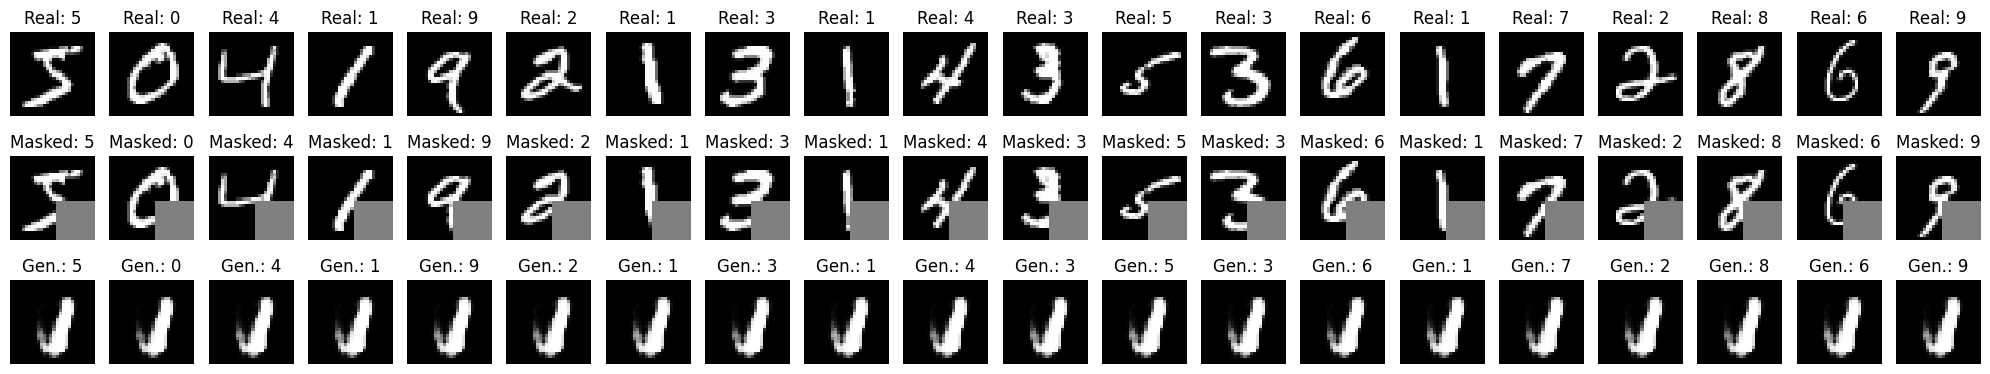

===============================!
Checkpoint 1


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.05846858


  5%|▌         | 100/1875 [00:10<03:03,  9.66it/s]

Total Loss: 2.44049072


 11%|█         | 200/1875 [00:21<02:56,  9.47it/s]

Total Loss: 2.33597517


 16%|█▌        | 300/1875 [00:31<02:47,  9.38it/s]

Total Loss: 2.19574451


 21%|██▏       | 400/1875 [00:42<02:35,  9.50it/s]

Total Loss: 2.43749833


 27%|██▋       | 500/1875 [00:52<02:23,  9.60it/s]

Total Loss: 2.3440547


 32%|███▏      | 600/1875 [01:03<02:12,  9.65it/s]

Total Loss: 2.49111414


 37%|███▋      | 700/1875 [01:13<02:04,  9.45it/s]

Total Loss: 2.42383361


 43%|████▎     | 800/1875 [01:24<01:51,  9.61it/s]

Total Loss: 2.10025215


 48%|████▊     | 900/1875 [01:34<01:41,  9.61it/s]

Total Loss: 3.02943182


 53%|█████▎    | 1000/1875 [01:44<01:31,  9.55it/s]

Total Loss: 2.44413614


 59%|█████▊    | 1100/1875 [01:55<01:21,  9.54it/s]

Total Loss: 2.1882031


 64%|██████▍   | 1200/1875 [02:05<01:10,  9.59it/s]

Total Loss: 2.28850174


 69%|██████▉   | 1300/1875 [02:16<00:59,  9.62it/s]

Total Loss: 2.34843159


 75%|███████▍  | 1400/1875 [02:26<00:49,  9.67it/s]

Total Loss: 2.18142986


 80%|████████  | 1500/1875 [02:37<00:39,  9.38it/s]

Total Loss: 2.33402658


 85%|████████▌ | 1600/1875 [02:47<00:28,  9.63it/s]

Total Loss: 2.21868229


 91%|█████████ | 1700/1875 [02:58<00:18,  9.60it/s]

Total Loss: 2.05716586


 96%|█████████▌| 1800/1875 [03:08<00:07,  9.54it/s]

Total Loss: 2.15075827


100%|██████████| 1875/1875 [03:21<00:00,  9.29it/s]


Time for epoch 1 is 201.91177558898926 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:12,  9.63it/s]

Total Loss: 2.22180176


  7%|▋         | 125/1875 [00:13<03:02,  9.59it/s]

Total Loss: 2.29337049


 12%|█▏        | 225/1875 [00:23<02:53,  9.49it/s]

Total Loss: 2.49279499


 17%|█▋        | 325/1875 [00:34<02:42,  9.56it/s]

Total Loss: 2.37443519


 23%|██▎       | 425/1875 [00:44<02:31,  9.57it/s]

Total Loss: 2.67679596


 28%|██▊       | 525/1875 [00:55<02:20,  9.60it/s]

Total Loss: 2.86105847


 33%|███▎      | 625/1875 [01:05<02:09,  9.62it/s]

Total Loss: 2.24378729


 39%|███▊      | 725/1875 [01:16<02:02,  9.36it/s]

Total Loss: 2.30426455


 44%|████▍     | 825/1875 [01:26<01:49,  9.61it/s]

Total Loss: 2.3094461


 49%|████▉     | 925/1875 [01:37<01:39,  9.55it/s]

Total Loss: 2.31268716


 55%|█████▍    | 1025/1875 [01:47<01:29,  9.55it/s]

Total Loss: 2.39400148


 60%|██████    | 1125/1875 [01:58<01:18,  9.55it/s]

Total Loss: 2.47740889


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.59it/s]

Total Loss: 2.35183334


 71%|███████   | 1325/1875 [02:19<00:57,  9.60it/s]

Total Loss: 2.22131705


 76%|███████▌  | 1425/1875 [02:29<00:47,  9.54it/s]

Total Loss: 2.3919034


 81%|████████▏ | 1525/1875 [02:40<00:36,  9.60it/s]

Total Loss: 2.7713623


 87%|████████▋ | 1625/1875 [02:50<00:25,  9.64it/s]

Total Loss: 2.35771561


 92%|█████████▏| 1725/1875 [03:01<00:15,  9.62it/s]

Total Loss: 2.05261254


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.62it/s]

Total Loss: 2.3507483


100%|██████████| 1875/1875 [03:16<00:00,  9.53it/s]


Time for epoch 2 is 196.70951890945435 sec
...
...
...
...


  3%|▎         | 50/1875 [00:05<03:10,  9.60it/s]

Total Loss: 2.55285978


  8%|▊         | 150/1875 [00:15<02:59,  9.59it/s]

Total Loss: 2.64122725


 13%|█▎        | 250/1875 [00:26<02:50,  9.53it/s]

Total Loss: 2.98419738


 19%|█▊        | 350/1875 [00:36<02:39,  9.55it/s]

Total Loss: 2.46464944


 24%|██▍       | 450/1875 [00:47<02:29,  9.50it/s]

Total Loss: 2.47203


 29%|██▉       | 550/1875 [00:57<02:18,  9.57it/s]

Total Loss: 2.23528266


 35%|███▍      | 650/1875 [01:08<02:07,  9.58it/s]

Total Loss: 2.57928491


 40%|████      | 750/1875 [01:18<01:57,  9.56it/s]

Total Loss: 2.24470758


 45%|████▌     | 850/1875 [01:29<01:47,  9.55it/s]

Total Loss: 2.22802973


 51%|█████     | 950/1875 [01:39<01:36,  9.58it/s]

Total Loss: 2.81856298


 56%|█████▌    | 1050/1875 [01:50<01:26,  9.57it/s]

Total Loss: 2.44832659


 61%|██████▏   | 1150/1875 [02:00<01:15,  9.58it/s]

Total Loss: 2.31472588


 67%|██████▋   | 1250/1875 [02:11<01:05,  9.61it/s]

Total Loss: 2.17662716


 72%|███████▏  | 1350/1875 [02:21<00:54,  9.64it/s]

Total Loss: 2.33742619


 77%|███████▋  | 1450/1875 [02:32<00:44,  9.59it/s]

Total Loss: 2.49633169


 83%|████████▎ | 1550/1875 [02:42<00:34,  9.50it/s]

Total Loss: 2.75305486


 88%|████████▊ | 1650/1875 [02:52<00:23,  9.59it/s]

Total Loss: 2.56797051


 93%|█████████▎| 1750/1875 [03:03<00:13,  9.55it/s]

Total Loss: 2.36984634


 99%|█████████▊| 1850/1875 [03:13<00:02,  9.61it/s]

Total Loss: 2.49828863


100%|██████████| 1875/1875 [03:16<00:00,  9.54it/s]


Time for epoch 3 is 196.52364325523376 sec
...
...
...
...


  4%|▍         | 75/1875 [00:07<03:15,  9.20it/s]

Total Loss: 2.5625658


  9%|▉         | 175/1875 [00:18<03:03,  9.27it/s]

Total Loss: 2.08551764


 15%|█▍        | 275/1875 [00:28<02:52,  9.25it/s]

Total Loss: 2.61149883


 20%|██        | 375/1875 [00:39<02:36,  9.60it/s]

Total Loss: 2.4720993


 25%|██▌       | 475/1875 [00:49<02:25,  9.60it/s]

Total Loss: 2.65244865


 31%|███       | 575/1875 [01:00<02:15,  9.62it/s]

Total Loss: 2.34585333


 36%|███▌      | 675/1875 [01:10<02:05,  9.58it/s]

Total Loss: 2.11865592


 41%|████▏     | 775/1875 [01:21<01:54,  9.58it/s]

Total Loss: 2.64348269


 47%|████▋     | 875/1875 [01:31<01:46,  9.37it/s]

Total Loss: 2.37419653


 52%|█████▏    | 975/1875 [01:42<01:33,  9.58it/s]

Total Loss: 2.20636892


 57%|█████▋    | 1075/1875 [01:52<01:23,  9.60it/s]

Total Loss: 2.60841489


 63%|██████▎   | 1175/1875 [02:03<01:12,  9.60it/s]

Total Loss: 2.52877808


 68%|██████▊   | 1275/1875 [02:13<01:02,  9.59it/s]

Total Loss: 2.13980055


 73%|███████▎  | 1375/1875 [02:24<00:52,  9.60it/s]

Total Loss: 2.2368505


 79%|███████▊  | 1475/1875 [02:34<00:41,  9.57it/s]

Total Loss: 2.29758835


 84%|████████▍ | 1575/1875 [02:45<00:31,  9.51it/s]

Total Loss: 2.48371267


 89%|████████▉ | 1675/1875 [02:55<00:20,  9.68it/s]

Total Loss: 2.27782965


 95%|█████████▍| 1775/1875 [03:05<00:10,  9.64it/s]

Total Loss: 2.31391335


100%|██████████| 1875/1875 [03:16<00:00,  9.55it/s]


Time for epoch 4 is 196.29441046714783 sec
...
...
...
...


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.3298409


  5%|▌         | 100/1875 [00:10<03:04,  9.61it/s]

Total Loss: 2.31854296


 11%|█         | 200/1875 [00:20<02:54,  9.61it/s]

Total Loss: 2.68167853


 16%|█▌        | 300/1875 [00:31<02:44,  9.57it/s]

Total Loss: 2.19619703


 21%|██▏       | 400/1875 [00:41<02:34,  9.57it/s]

Total Loss: 2.59813929


 27%|██▋       | 500/1875 [00:52<02:26,  9.39it/s]

Total Loss: 2.43027925


 32%|███▏      | 600/1875 [01:02<02:12,  9.60it/s]

Total Loss: 2.31022716


 37%|███▋      | 700/1875 [01:13<02:02,  9.59it/s]

Total Loss: 2.35453439


 43%|████▎     | 800/1875 [01:23<01:52,  9.56it/s]

Total Loss: 2.27905416


 48%|████▊     | 900/1875 [01:34<01:41,  9.59it/s]

Total Loss: 2.4130249


 53%|█████▎    | 1000/1875 [01:44<01:31,  9.58it/s]

Total Loss: 2.07546973


 59%|█████▊    | 1100/1875 [01:55<01:20,  9.59it/s]

Total Loss: 2.55469203


 64%|██████▍   | 1200/1875 [02:05<01:11,  9.42it/s]

Total Loss: 2.17656898


 69%|██████▉   | 1300/1875 [02:16<01:00,  9.51it/s]

Total Loss: 2.34299278


 75%|███████▍  | 1400/1875 [02:26<00:49,  9.57it/s]

Total Loss: 2.94104671


 80%|████████  | 1500/1875 [02:37<00:38,  9.62it/s]

Total Loss: 2.16362715


 85%|████████▌ | 1600/1875 [02:47<00:28,  9.59it/s]

Total Loss: 2.36736441


 91%|█████████ | 1700/1875 [02:57<00:18,  9.61it/s]

Total Loss: 2.51531053


 96%|█████████▌| 1800/1875 [03:08<00:07,  9.59it/s]

Total Loss: 2.15452981


100%|██████████| 1875/1875 [03:16<00:00,  9.55it/s]


Time for epoch 5 is 196.30511784553528 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:11,  9.65it/s]

Total Loss: 2.38852954


  7%|▋         | 125/1875 [00:13<03:08,  9.26it/s]

Total Loss: 2.42737317


 12%|█▏        | 225/1875 [00:23<02:52,  9.55it/s]

Total Loss: 2.27325177


 17%|█▋        | 325/1875 [00:34<02:40,  9.65it/s]

Total Loss: 2.8536818


 23%|██▎       | 425/1875 [00:44<02:31,  9.60it/s]

Total Loss: 2.34261584


 28%|██▊       | 525/1875 [00:54<02:20,  9.63it/s]

Total Loss: 2.37446404


 33%|███▎      | 625/1875 [01:05<02:12,  9.45it/s]

Total Loss: 2.54847622


 39%|███▊      | 725/1875 [01:15<02:01,  9.45it/s]

Total Loss: 2.58093953


 44%|████▍     | 825/1875 [01:26<01:49,  9.56it/s]

Total Loss: 2.26641631


 49%|████▉     | 925/1875 [01:36<01:39,  9.59it/s]

Total Loss: 2.23943663


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.61it/s]

Total Loss: 2.49885798


 60%|██████    | 1125/1875 [01:57<01:18,  9.60it/s]

Total Loss: 2.3435235


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.61it/s]

Total Loss: 2.58870625


 71%|███████   | 1325/1875 [02:18<00:57,  9.62it/s]

Total Loss: 2.47581744


 76%|███████▌  | 1425/1875 [02:29<00:46,  9.61it/s]

Total Loss: 2.60266852


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.53it/s]

Total Loss: 2.50805235


 87%|████████▋ | 1625/1875 [02:50<00:27,  9.17it/s]

Total Loss: 2.91078329


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.67it/s]

Total Loss: 2.23585


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.63it/s]

Total Loss: 2.91240883


100%|██████████| 1875/1875 [03:16<00:00,  9.53it/s]


Time for epoch 6 is 196.721745967865 sec
...
...
...
...


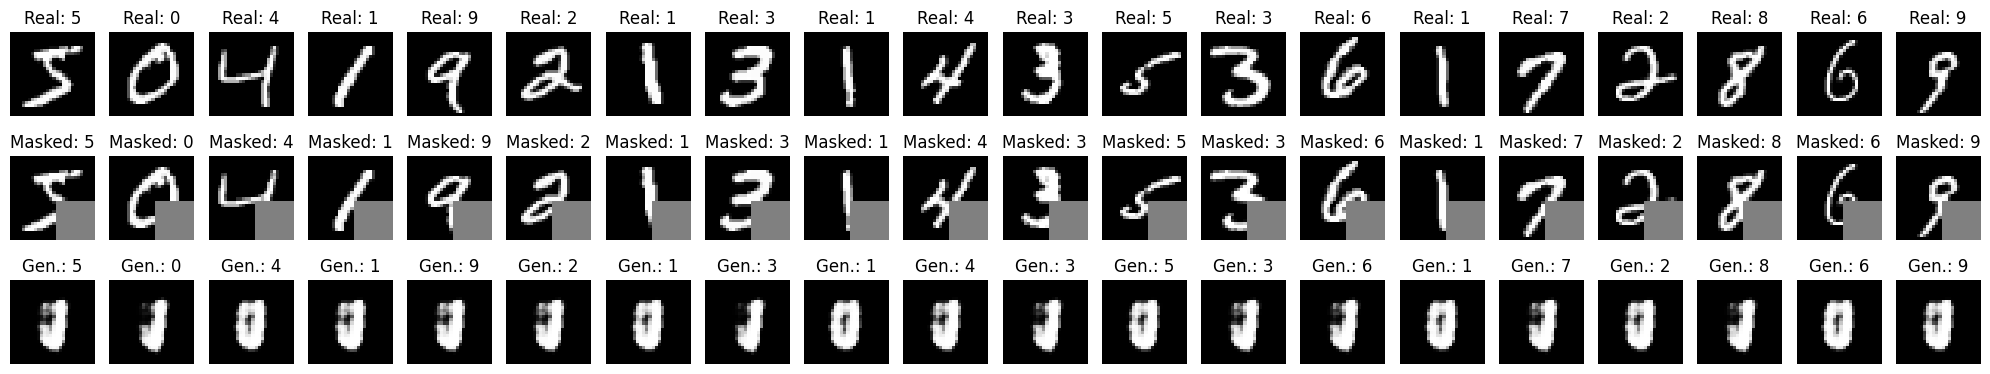

===============================!
Checkpoint 2


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.32400942


  5%|▌         | 100/1875 [00:10<03:03,  9.67it/s]

Total Loss: 2.11643839


 11%|█         | 200/1875 [00:21<02:57,  9.45it/s]

Total Loss: 2.10652113


 16%|█▌        | 300/1875 [00:31<02:46,  9.45it/s]

Total Loss: 2.32020187


 21%|██▏       | 400/1875 [00:42<02:35,  9.51it/s]

Total Loss: 2.25581527


 27%|██▋       | 500/1875 [00:52<02:23,  9.58it/s]

Total Loss: 2.46078825


 32%|███▏      | 600/1875 [01:03<02:12,  9.65it/s]

Total Loss: 2.62715697


 37%|███▋      | 700/1875 [01:13<02:09,  9.08it/s]

Total Loss: 2.47235537


 43%|████▎     | 800/1875 [01:24<01:53,  9.46it/s]

Total Loss: 2.46889758


 48%|████▊     | 900/1875 [01:34<01:41,  9.63it/s]

Total Loss: 2.35035062


 53%|█████▎    | 1000/1875 [01:45<01:31,  9.54it/s]

Total Loss: 2.46396303


 59%|█████▊    | 1100/1875 [01:55<01:20,  9.58it/s]

Total Loss: 2.61863852


 64%|██████▍   | 1200/1875 [02:06<01:10,  9.55it/s]

Total Loss: 2.32566261


 69%|██████▉   | 1300/1875 [02:16<00:59,  9.65it/s]

Total Loss: 2.2700398


 75%|███████▍  | 1400/1875 [02:27<00:49,  9.54it/s]

Total Loss: 2.5155077


 80%|████████  | 1500/1875 [02:37<00:39,  9.38it/s]

Total Loss: 2.25501633


 85%|████████▌ | 1600/1875 [02:48<00:28,  9.64it/s]

Total Loss: 3.39305019


 91%|█████████ | 1700/1875 [02:58<00:18,  9.63it/s]

Total Loss: 2.35553646


 96%|█████████▌| 1800/1875 [03:09<00:07,  9.58it/s]

Total Loss: 2.52119279


100%|██████████| 1875/1875 [03:17<00:00,  9.51it/s]


Time for epoch 1 is 197.10681557655334 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:11,  9.64it/s]

Total Loss: 2.46178699


  7%|▋         | 125/1875 [00:13<03:02,  9.61it/s]

Total Loss: 2.05491257


 12%|█▏        | 225/1875 [00:23<02:51,  9.63it/s]

Total Loss: 2.66077185


 17%|█▋        | 325/1875 [00:34<02:48,  9.22it/s]

Total Loss: 2.78999662


 23%|██▎       | 425/1875 [00:44<02:34,  9.39it/s]

Total Loss: 2.19210243


 28%|██▊       | 525/1875 [00:55<02:21,  9.57it/s]

Total Loss: 2.55520797


 33%|███▎      | 625/1875 [01:05<02:10,  9.59it/s]

Total Loss: 2.41351414


 39%|███▊      | 725/1875 [01:16<02:00,  9.55it/s]

Total Loss: 2.35832858


 44%|████▍     | 825/1875 [01:26<01:49,  9.58it/s]

Total Loss: 2.34303522


 49%|████▉     | 925/1875 [01:37<01:39,  9.59it/s]

Total Loss: 2.19355


 55%|█████▍    | 1025/1875 [01:47<01:29,  9.54it/s]

Total Loss: 2.34392142


 60%|██████    | 1125/1875 [01:58<01:21,  9.25it/s]

Total Loss: 2.06388092


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.58it/s]

Total Loss: 2.14905906


 71%|███████   | 1325/1875 [02:19<00:57,  9.58it/s]

Total Loss: 2.49094439


 76%|███████▌  | 1425/1875 [02:29<00:47,  9.56it/s]

Total Loss: 2.59408593


 81%|████████▏ | 1525/1875 [02:40<00:36,  9.57it/s]

Total Loss: 2.30133057


 87%|████████▋ | 1625/1875 [02:50<00:26,  9.59it/s]

Total Loss: 2.38760853


 92%|█████████▏| 1725/1875 [03:01<00:15,  9.62it/s]

Total Loss: 2.91918659


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.56it/s]

Total Loss: 2.76035738


100%|██████████| 1875/1875 [03:16<00:00,  9.53it/s]


Time for epoch 2 is 196.81445789337158 sec
...
...
...
...


  3%|▎         | 50/1875 [00:05<03:11,  9.54it/s]

Total Loss: 2.18152452


  8%|▊         | 150/1875 [00:15<03:00,  9.56it/s]

Total Loss: 2.66685176


 13%|█▎        | 250/1875 [00:26<02:49,  9.58it/s]

Total Loss: 1.90300417


 19%|█▊        | 350/1875 [00:36<02:38,  9.60it/s]

Total Loss: 2.28075266


 24%|██▍       | 450/1875 [00:47<02:28,  9.63it/s]

Total Loss: 2.15524483


 29%|██▉       | 550/1875 [00:57<02:18,  9.59it/s]

Total Loss: 2.1414628


 35%|███▍      | 650/1875 [01:08<02:08,  9.55it/s]

Total Loss: 2.23937774


 40%|████      | 750/1875 [01:18<01:59,  9.44it/s]

Total Loss: 2.54890561


 45%|████▌     | 850/1875 [01:29<01:47,  9.54it/s]

Total Loss: 2.31233859


 51%|█████     | 950/1875 [01:39<01:36,  9.59it/s]

Total Loss: 2.32942104


 56%|█████▌    | 1050/1875 [01:50<01:25,  9.60it/s]

Total Loss: 2.62250185


 61%|██████▏   | 1150/1875 [02:00<01:15,  9.61it/s]

Total Loss: 2.30442238


 67%|██████▋   | 1250/1875 [02:11<01:04,  9.64it/s]

Total Loss: 2.24025488


 72%|███████▏  | 1349/1875 [02:21<00:55,  9.42it/s]

Total Loss: 2.15952969


 77%|███████▋  | 1450/1875 [02:32<00:44,  9.64it/s]

Total Loss: 2.63259292


 83%|████████▎ | 1550/1875 [02:42<00:35,  9.24it/s]

Total Loss: 2.0535605


 88%|████████▊ | 1650/1875 [02:53<00:23,  9.59it/s]

Total Loss: 2.23570585


 93%|█████████▎| 1750/1875 [03:03<00:13,  9.61it/s]

Total Loss: 2.27132535


 99%|█████████▊| 1850/1875 [03:14<00:02,  9.61it/s]

Total Loss: 2.03206587


100%|██████████| 1875/1875 [03:16<00:00,  9.53it/s]


Time for epoch 3 is 196.73336577415466 sec
...
...
...
...


  4%|▍         | 75/1875 [00:07<03:07,  9.59it/s]

Total Loss: 2.29152489


  9%|▉         | 175/1875 [00:18<02:56,  9.61it/s]

Total Loss: 2.49225473


 15%|█▍        | 275/1875 [00:28<02:47,  9.56it/s]

Total Loss: 2.17116737


 20%|██        | 375/1875 [00:39<02:36,  9.56it/s]

Total Loss: 2.68243694


 25%|██▌       | 475/1875 [00:49<02:26,  9.56it/s]

Total Loss: 2.61521721


 31%|███       | 575/1875 [01:00<02:15,  9.58it/s]

Total Loss: 2.28678393


 36%|███▌      | 675/1875 [01:10<02:05,  9.57it/s]

Total Loss: 2.37699771


 41%|████▏     | 775/1875 [01:21<01:54,  9.60it/s]

Total Loss: 2.86503744


 47%|████▋     | 875/1875 [01:31<01:44,  9.60it/s]

Total Loss: 2.19335985


 52%|█████▏    | 975/1875 [01:42<01:33,  9.62it/s]

Total Loss: 2.34801865


 57%|█████▋    | 1075/1875 [01:52<01:23,  9.63it/s]

Total Loss: 2.57460475


 63%|██████▎   | 1175/1875 [02:02<01:17,  8.99it/s]

Total Loss: 2.3478086


 68%|██████▊   | 1275/1875 [02:13<01:02,  9.67it/s]

Total Loss: 2.29288483


 73%|███████▎  | 1375/1875 [02:23<00:51,  9.65it/s]

Total Loss: 2.1224339


 79%|███████▊  | 1475/1875 [02:34<00:41,  9.61it/s]

Total Loss: 2.2685771


 84%|████████▍ | 1575/1875 [02:44<00:31,  9.61it/s]

Total Loss: 1.99879086


 89%|████████▉ | 1675/1875 [02:55<00:20,  9.57it/s]

Total Loss: 2.16760826


 95%|█████████▍| 1775/1875 [03:05<00:10,  9.56it/s]

Total Loss: 2.40809679


100%|██████████| 1875/1875 [03:16<00:00,  9.56it/s]


Time for epoch 4 is 196.23957228660583 sec
...
...
...
...


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.25602746


  5%|▌         | 100/1875 [00:10<03:16,  9.03it/s]

Total Loss: 2.36921358


 11%|█         | 200/1875 [00:21<02:54,  9.58it/s]

Total Loss: 2.52454615


 16%|█▌        | 300/1875 [00:31<02:45,  9.53it/s]

Total Loss: 2.55952668


 21%|██▏       | 400/1875 [00:42<02:33,  9.60it/s]

Total Loss: 2.36073542


 27%|██▋       | 500/1875 [00:52<02:24,  9.52it/s]

Total Loss: 2.18762445


 32%|███▏      | 600/1875 [01:02<02:13,  9.54it/s]

Total Loss: 2.3422122


 37%|███▋      | 700/1875 [01:13<02:02,  9.60it/s]

Total Loss: 2.02638388


 43%|████▎     | 800/1875 [01:23<01:52,  9.58it/s]

Total Loss: 2.45703554


 48%|████▊     | 900/1875 [01:34<01:45,  9.26it/s]

Total Loss: 2.70535922


 53%|█████▎    | 1000/1875 [01:44<01:31,  9.60it/s]

Total Loss: 2.29713154


 59%|█████▊    | 1100/1875 [01:55<01:21,  9.56it/s]

Total Loss: 2.36099029


 64%|██████▍   | 1200/1875 [02:05<01:10,  9.58it/s]

Total Loss: 2.65848017


 69%|██████▉   | 1300/1875 [02:16<00:59,  9.58it/s]

Total Loss: 2.28724122


 75%|███████▍  | 1400/1875 [02:26<00:49,  9.56it/s]

Total Loss: 2.95318222


 80%|████████  | 1500/1875 [02:37<00:38,  9.63it/s]

Total Loss: 2.81428051


 85%|████████▌ | 1600/1875 [02:47<00:29,  9.35it/s]

Total Loss: 2.47984123


 91%|█████████ | 1700/1875 [02:58<00:18,  9.51it/s]

Total Loss: 2.3266747


 96%|█████████▌| 1800/1875 [03:08<00:07,  9.59it/s]

Total Loss: 2.66740203


100%|██████████| 1875/1875 [03:16<00:00,  9.54it/s]


Time for epoch 5 is 196.64567875862122 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:12,  9.61it/s]

Total Loss: 2.64445662


  7%|▋         | 125/1875 [00:13<03:03,  9.53it/s]

Total Loss: 2.72923589


 12%|█▏        | 225/1875 [00:23<02:51,  9.61it/s]

Total Loss: 2.58703613


 17%|█▋        | 325/1875 [00:34<02:41,  9.61it/s]

Total Loss: 2.54067659


 23%|██▎       | 425/1875 [00:44<02:30,  9.63it/s]

Total Loss: 2.75935078


 28%|██▊       | 525/1875 [00:54<02:24,  9.35it/s]

Total Loss: 2.28432417


 33%|███▎      | 625/1875 [01:05<02:09,  9.64it/s]

Total Loss: 2.52641392


 39%|███▊      | 725/1875 [01:15<01:59,  9.62it/s]

Total Loss: 2.48756218


 44%|████▍     | 825/1875 [01:26<01:49,  9.57it/s]

Total Loss: 2.28767967


 49%|████▉     | 925/1875 [01:36<01:38,  9.60it/s]

Total Loss: 2.43103695


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.59it/s]

Total Loss: 2.3206768


 60%|██████    | 1125/1875 [01:57<01:17,  9.62it/s]

Total Loss: 2.42647576


 65%|██████▌   | 1225/1875 [02:08<01:08,  9.54it/s]

Total Loss: 2.61426902


 71%|███████   | 1325/1875 [02:18<00:57,  9.63it/s]

Total Loss: 2.42444491


 76%|███████▌  | 1425/1875 [02:29<00:46,  9.60it/s]

Total Loss: 2.38190818


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.58it/s]

Total Loss: 2.4153254


 87%|████████▋ | 1625/1875 [02:49<00:26,  9.60it/s]

Total Loss: 2.3426075


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.59it/s]

Total Loss: 2.17777538


 97%|█████████▋| 1825/1875 [03:10<00:05,  9.57it/s]

Total Loss: 2.33552241


100%|██████████| 1875/1875 [03:16<00:00,  9.56it/s]


Time for epoch 6 is 196.14071559906006 sec
...
...
...
...


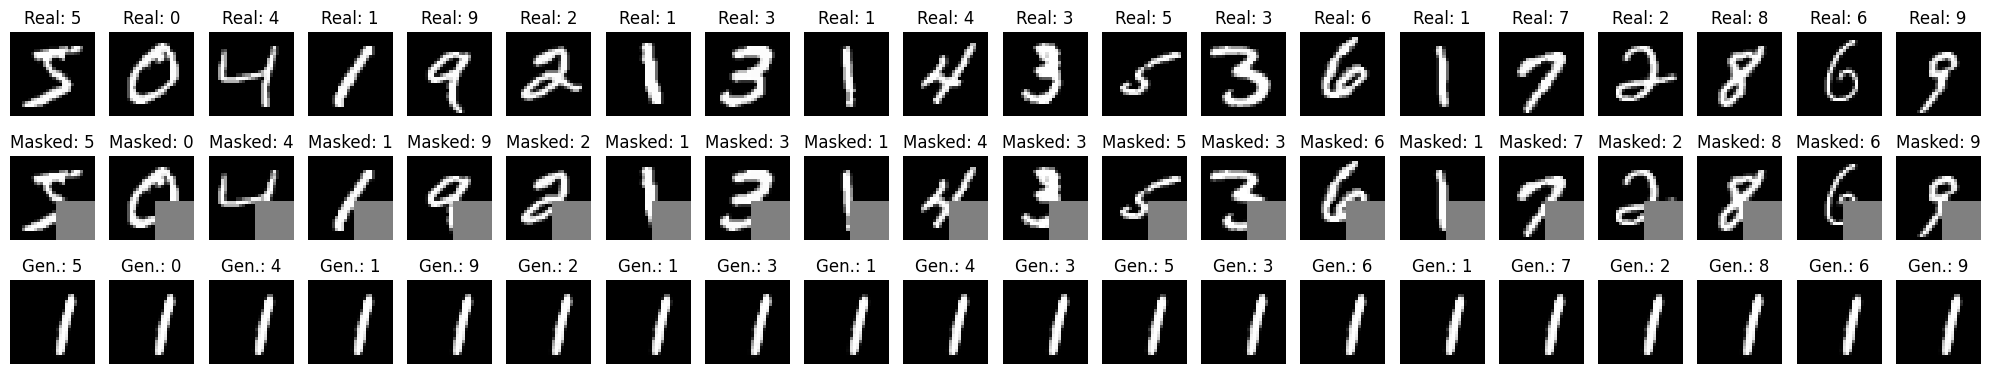

===============================!
Checkpoint 3


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.65622807


  5%|▌         | 100/1875 [00:10<03:06,  9.51it/s]

Total Loss: 2.46576738


 11%|█         | 200/1875 [00:21<02:57,  9.44it/s]

Total Loss: 2.42895675


 16%|█▌        | 300/1875 [00:31<02:47,  9.38it/s]

Total Loss: 2.42377257


 21%|██▏       | 400/1875 [00:42<02:38,  9.34it/s]

Total Loss: 2.21007204


 27%|██▋       | 500/1875 [00:52<02:23,  9.58it/s]

Total Loss: 2.2133255


 32%|███▏      | 600/1875 [01:03<02:12,  9.60it/s]

Total Loss: 2.59812546


 37%|███▋      | 700/1875 [01:13<02:02,  9.58it/s]

Total Loss: 2.47539353


 43%|████▎     | 800/1875 [01:24<01:51,  9.62it/s]

Total Loss: 2.20821047


 48%|████▊     | 900/1875 [01:34<01:41,  9.58it/s]

Total Loss: 2.59806347


 53%|█████▎    | 1000/1875 [01:45<01:31,  9.54it/s]

Total Loss: 3.09441495


 59%|█████▊    | 1100/1875 [01:55<01:22,  9.36it/s]

Total Loss: 2.90527


 64%|██████▍   | 1200/1875 [02:06<01:10,  9.51it/s]

Total Loss: 2.32850242


 69%|██████▉   | 1300/1875 [02:16<00:59,  9.59it/s]

Total Loss: 2.55749345


 75%|███████▍  | 1400/1875 [02:27<00:49,  9.55it/s]

Total Loss: 2.654953


 80%|████████  | 1500/1875 [02:37<00:39,  9.59it/s]

Total Loss: 2.26103663


 85%|████████▌ | 1600/1875 [02:48<00:28,  9.66it/s]

Total Loss: 2.44275713


 91%|█████████ | 1700/1875 [02:58<00:18,  9.55it/s]

Total Loss: 2.37030268


 96%|█████████▌| 1800/1875 [03:09<00:07,  9.47it/s]

Total Loss: 2.72607565


100%|██████████| 1875/1875 [03:17<00:00,  9.51it/s]


Time for epoch 1 is 197.06754851341248 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:12,  9.63it/s]

Total Loss: 2.19169


  7%|▋         | 125/1875 [00:13<03:02,  9.61it/s]

Total Loss: 2.68496299


 12%|█▏        | 225/1875 [00:23<02:51,  9.61it/s]

Total Loss: 1.98087883


 17%|█▋        | 325/1875 [00:34<02:41,  9.62it/s]

Total Loss: 2.52939177


 23%|██▎       | 425/1875 [00:44<02:31,  9.60it/s]

Total Loss: 2.96535516


 28%|██▊       | 525/1875 [00:54<02:20,  9.63it/s]

Total Loss: 2.51830816


 33%|███▎      | 625/1875 [01:05<02:09,  9.63it/s]

Total Loss: 2.81691504


 39%|███▊      | 725/1875 [01:15<02:07,  9.02it/s]

Total Loss: 2.3631413


 44%|████▍     | 825/1875 [01:26<01:55,  9.12it/s]

Total Loss: 2.51531696


 49%|████▉     | 925/1875 [01:36<01:39,  9.56it/s]

Total Loss: 2.64146614


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.61it/s]

Total Loss: 2.2888751


 60%|██████    | 1125/1875 [01:57<01:18,  9.61it/s]

Total Loss: 2.16389108


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.62it/s]

Total Loss: 2.46385455


 71%|███████   | 1325/1875 [02:18<00:57,  9.62it/s]

Total Loss: 2.42638803


 76%|███████▌  | 1425/1875 [02:29<00:47,  9.52it/s]

Total Loss: 2.47882056


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.56it/s]

Total Loss: 2.55348659


 87%|████████▋ | 1625/1875 [02:50<00:26,  9.57it/s]

Total Loss: 2.497118


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.55it/s]

Total Loss: 2.50546551


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.57it/s]

Total Loss: 3.09463143


100%|██████████| 1875/1875 [03:16<00:00,  9.54it/s]


Time for epoch 2 is 196.64103412628174 sec
...
...
...
...


  3%|▎         | 50/1875 [00:05<03:10,  9.56it/s]

Total Loss: 2.58228922


  8%|▊         | 150/1875 [00:15<02:58,  9.64it/s]

Total Loss: 2.15248728


 13%|█▎        | 250/1875 [00:26<02:49,  9.59it/s]

Total Loss: 2.41219902


 19%|█▊        | 350/1875 [00:36<02:40,  9.51it/s]

Total Loss: 2.23962331


 24%|██▍       | 450/1875 [00:47<02:28,  9.61it/s]

Total Loss: 2.23503971


 29%|██▉       | 550/1875 [00:57<02:18,  9.58it/s]

Total Loss: 2.31425261


 35%|███▍      | 650/1875 [01:08<02:07,  9.60it/s]

Total Loss: 2.53694439


 40%|████      | 750/1875 [01:18<01:57,  9.58it/s]

Total Loss: 2.04870987


 45%|████▌     | 850/1875 [01:29<01:46,  9.59it/s]

Total Loss: 2.5135448


 51%|█████     | 950/1875 [01:39<01:36,  9.55it/s]

Total Loss: 2.30703878


 56%|█████▌    | 1050/1875 [01:50<01:26,  9.58it/s]

Total Loss: 2.574049


 61%|██████▏   | 1150/1875 [02:00<01:17,  9.30it/s]

Total Loss: 2.50970674


 67%|██████▋   | 1250/1875 [02:11<01:05,  9.50it/s]

Total Loss: 2.52993035


 72%|███████▏  | 1350/1875 [02:21<00:54,  9.59it/s]

Total Loss: 2.63405252


 77%|███████▋  | 1450/1875 [02:32<00:44,  9.56it/s]

Total Loss: 2.34970093


 83%|████████▎ | 1550/1875 [02:42<00:33,  9.60it/s]

Total Loss: 2.60172033


 88%|████████▊ | 1650/1875 [02:53<00:23,  9.60it/s]

Total Loss: 2.70849085


 93%|█████████▎| 1750/1875 [03:03<00:13,  9.59it/s]

Total Loss: 2.23264456


 99%|█████████▊| 1850/1875 [03:14<00:02,  9.49it/s]

Total Loss: 2.86853027


100%|██████████| 1875/1875 [03:16<00:00,  9.53it/s]


Time for epoch 3 is 196.74918842315674 sec
...
...
...
...


  4%|▍         | 75/1875 [00:07<03:09,  9.52it/s]

Total Loss: 2.68372631


  9%|▉         | 175/1875 [00:18<02:57,  9.56it/s]

Total Loss: 2.4193666


 15%|█▍        | 275/1875 [00:28<02:46,  9.61it/s]

Total Loss: 2.48691177


 20%|██        | 375/1875 [00:39<02:35,  9.62it/s]

Total Loss: 2.57852149


 25%|██▌       | 475/1875 [00:49<02:26,  9.57it/s]

Total Loss: 2.08825493


 31%|███       | 575/1875 [01:00<02:15,  9.59it/s]

Total Loss: 2.21253181


 36%|███▌      | 675/1875 [01:11<02:05,  9.53it/s]

Total Loss: 2.35569143


 41%|████▏     | 775/1875 [01:21<01:56,  9.45it/s]

Total Loss: 2.50878763


 47%|████▋     | 875/1875 [01:32<01:44,  9.60it/s]

Total Loss: 2.52640581


 52%|█████▏    | 975/1875 [01:42<01:33,  9.59it/s]

Total Loss: 2.47203803


 57%|█████▋    | 1075/1875 [01:53<01:24,  9.45it/s]

Total Loss: 1.9884584


 63%|██████▎   | 1175/1875 [02:03<01:13,  9.57it/s]

Total Loss: 2.23751068


 68%|██████▊   | 1275/1875 [02:14<01:02,  9.56it/s]

Total Loss: 2.32970715


 73%|███████▎  | 1375/1875 [02:24<00:52,  9.58it/s]

Total Loss: 2.34489202


 79%|███████▊  | 1475/1875 [02:35<00:43,  9.23it/s]

Total Loss: 2.5730927


 84%|████████▍ | 1575/1875 [02:45<00:32,  9.36it/s]

Total Loss: 2.27914476


 89%|████████▉ | 1675/1875 [02:56<00:20,  9.59it/s]

Total Loss: 2.1763


 95%|█████████▍| 1775/1875 [03:06<00:10,  9.57it/s]

Total Loss: 2.37685871


100%|██████████| 1875/1875 [03:17<00:00,  9.50it/s]


Time for epoch 4 is 197.31209063529968 sec
...
...
...
...


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.46337128


  5%|▌         | 100/1875 [00:10<03:05,  9.55it/s]

Total Loss: 2.33124042


 11%|█         | 200/1875 [00:21<02:55,  9.56it/s]

Total Loss: 2.24426293


 16%|█▌        | 300/1875 [00:31<02:44,  9.58it/s]

Total Loss: 2.06718826


 21%|██▏       | 400/1875 [00:42<02:37,  9.35it/s]

Total Loss: 1.99533927


 27%|██▋       | 500/1875 [00:52<02:23,  9.57it/s]

Total Loss: 2.58410311


 32%|███▏      | 600/1875 [01:03<02:14,  9.51it/s]

Total Loss: 2.49313474


 37%|███▋      | 700/1875 [01:13<02:02,  9.58it/s]

Total Loss: 2.76081729


 43%|████▎     | 800/1875 [01:24<01:52,  9.55it/s]

Total Loss: 2.52142262


 48%|████▊     | 900/1875 [01:34<01:41,  9.62it/s]

Total Loss: 2.54435873


 53%|█████▎    | 1000/1875 [01:45<01:31,  9.55it/s]

Total Loss: 2.04360342


 59%|█████▊    | 1100/1875 [01:55<01:28,  8.77it/s]

Total Loss: 2.1945672


 64%|██████▍   | 1200/1875 [02:06<01:10,  9.59it/s]

Total Loss: 2.31037354


 69%|██████▉   | 1300/1875 [02:16<01:00,  9.56it/s]

Total Loss: 2.2655952


 75%|███████▍  | 1400/1875 [02:27<00:49,  9.56it/s]

Total Loss: 2.54826379


 80%|████████  | 1500/1875 [02:37<00:39,  9.60it/s]

Total Loss: 2.47648335


 85%|████████▌ | 1600/1875 [02:48<00:28,  9.55it/s]

Total Loss: 2.37716198


 91%|█████████ | 1700/1875 [02:58<00:18,  9.61it/s]

Total Loss: 2.58147264


 96%|█████████▌| 1800/1875 [03:09<00:07,  9.53it/s]

Total Loss: 2.08425307


100%|██████████| 1875/1875 [03:17<00:00,  9.50it/s]


Time for epoch 5 is 197.28049778938293 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:20,  9.24it/s]

Total Loss: 2.39886713


  7%|▋         | 125/1875 [00:13<03:02,  9.58it/s]

Total Loss: 2.25007844


 12%|█▏        | 225/1875 [00:23<02:52,  9.55it/s]

Total Loss: 2.33457947


 17%|█▋        | 325/1875 [00:34<02:41,  9.58it/s]

Total Loss: 2.44646192


 23%|██▎       | 425/1875 [00:44<02:31,  9.54it/s]

Total Loss: 2.11971831


 28%|██▊       | 525/1875 [00:55<02:20,  9.59it/s]

Total Loss: 2.31178904


 33%|███▎      | 625/1875 [01:05<02:11,  9.53it/s]

Total Loss: 2.14816475


 39%|███▊      | 725/1875 [01:16<02:02,  9.39it/s]

Total Loss: 2.26055622


 44%|████▍     | 825/1875 [01:26<01:54,  9.15it/s]

Total Loss: 2.23135948


 49%|████▉     | 925/1875 [01:37<01:38,  9.62it/s]

Total Loss: 2.45736504


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.65it/s]

Total Loss: 2.13438106


 60%|██████    | 1125/1875 [01:58<01:17,  9.66it/s]

Total Loss: 2.78583193


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.62it/s]

Total Loss: 2.16769505


 71%|███████   | 1325/1875 [02:18<00:57,  9.63it/s]

Total Loss: 2.67739439


 76%|███████▌  | 1425/1875 [02:29<00:46,  9.62it/s]

Total Loss: 2.59865952


 81%|████████▏ | 1525/1875 [02:39<00:36,  9.54it/s]

Total Loss: 2.02476978


 87%|████████▋ | 1625/1875 [02:50<00:26,  9.61it/s]

Total Loss: 2.50260115


 92%|█████████▏| 1725/1875 [03:00<00:15,  9.60it/s]

Total Loss: 2.43308783


 97%|█████████▋| 1825/1875 [03:11<00:05,  9.59it/s]

Total Loss: 2.71869421


100%|██████████| 1875/1875 [03:21<00:00,  9.29it/s]


Time for epoch 6 is 201.91568326950073 sec
...
...
...
...


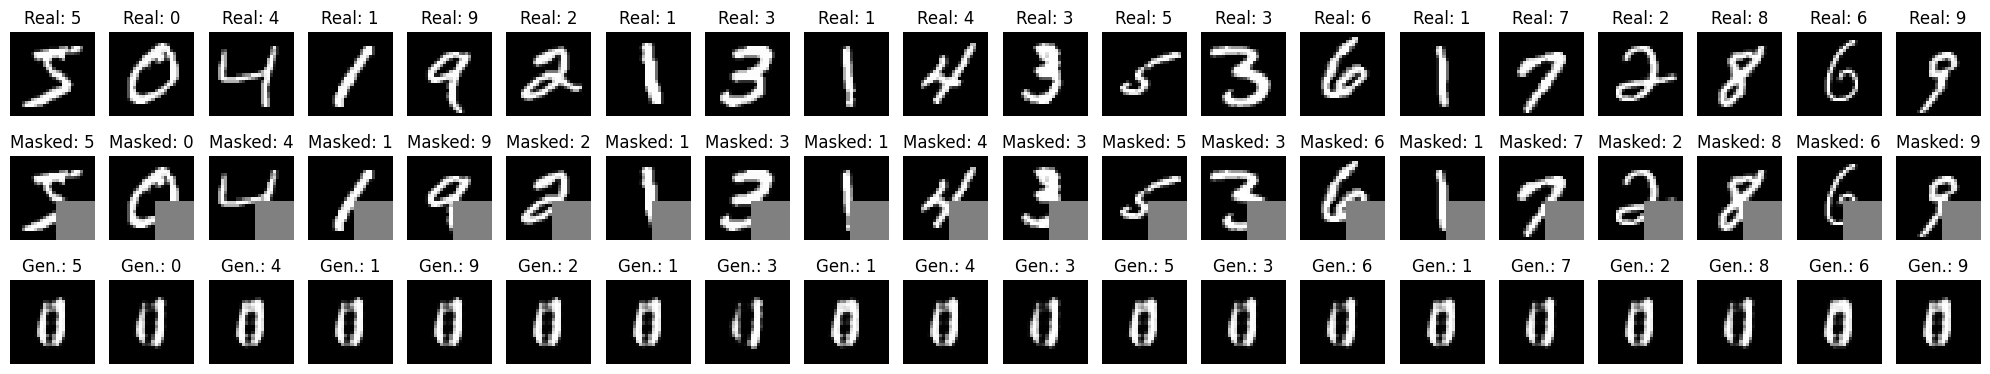

===============================!
Checkpoint 4


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.35431838


  5%|▌         | 100/1875 [00:10<03:03,  9.65it/s]

Total Loss: 2.25606298


 11%|█         | 200/1875 [00:21<02:57,  9.43it/s]

Total Loss: 2.3895421


 16%|█▌        | 300/1875 [00:31<02:47,  9.38it/s]

Total Loss: 2.36533928


 21%|██▏       | 400/1875 [00:42<02:34,  9.54it/s]

Total Loss: 2.39709115


 27%|██▋       | 500/1875 [00:52<02:23,  9.61it/s]

Total Loss: 2.70492458


 32%|███▏      | 600/1875 [01:03<02:13,  9.57it/s]

Total Loss: 2.40134358


 37%|███▋      | 700/1875 [01:13<02:01,  9.66it/s]

Total Loss: 2.32699132


 43%|████▎     | 800/1875 [01:24<01:51,  9.65it/s]

Total Loss: 2.84587264


 48%|████▊     | 900/1875 [01:34<01:41,  9.60it/s]

Total Loss: 2.7060051


 53%|█████▎    | 1000/1875 [01:45<01:33,  9.34it/s]

Total Loss: 2.49490833


 59%|█████▊    | 1100/1875 [01:56<01:23,  9.28it/s]

Total Loss: 2.49769163


 64%|██████▍   | 1200/1875 [02:07<01:10,  9.55it/s]

Total Loss: 2.50578547


 69%|██████▉   | 1300/1875 [02:17<01:00,  9.56it/s]

Total Loss: 2.67412758


 75%|███████▍  | 1400/1875 [02:28<00:49,  9.50it/s]

Total Loss: 2.75051475


 80%|████████  | 1500/1875 [02:38<00:39,  9.59it/s]

Total Loss: 2.25055599


 85%|████████▌ | 1600/1875 [02:49<00:28,  9.55it/s]

Total Loss: 2.47793841


 91%|█████████ | 1700/1875 [02:59<00:18,  9.59it/s]

Total Loss: 2.45770669


 96%|█████████▌| 1799/1875 [03:10<00:08,  9.31it/s]

Total Loss: 2.44278812


100%|██████████| 1875/1875 [03:17<00:00,  9.47it/s]


Time for epoch 1 is 197.99775385856628 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:13,  9.58it/s]

Total Loss: 2.75533414


  7%|▋         | 125/1875 [00:13<03:02,  9.57it/s]

Total Loss: 2.48689747


 12%|█▏        | 225/1875 [00:23<02:52,  9.57it/s]

Total Loss: 2.29772925


 17%|█▋        | 325/1875 [00:34<02:42,  9.56it/s]

Total Loss: 2.58019614


 23%|██▎       | 425/1875 [00:44<02:31,  9.60it/s]

Total Loss: 2.86975551


 28%|██▊       | 525/1875 [00:55<02:21,  9.55it/s]

Total Loss: 2.83501244


 33%|███▎      | 625/1875 [01:05<02:11,  9.53it/s]

Total Loss: 2.21032476


 39%|███▊      | 725/1875 [01:16<02:01,  9.46it/s]

Total Loss: 2.59351826


 44%|████▍     | 825/1875 [01:26<01:49,  9.55it/s]

Total Loss: 2.55988884


 49%|████▉     | 925/1875 [01:37<01:39,  9.59it/s]

Total Loss: 2.43205547


 55%|█████▍    | 1025/1875 [01:47<01:28,  9.59it/s]

Total Loss: 2.43088794


 60%|██████    | 1125/1875 [01:58<01:17,  9.63it/s]

Total Loss: 2.18315935


 65%|██████▌   | 1225/1875 [02:08<01:07,  9.57it/s]

Total Loss: 2.83146811


 71%|███████   | 1325/1875 [02:19<00:57,  9.55it/s]

Total Loss: 2.07096219


 76%|███████▌  | 1425/1875 [02:30<00:50,  8.99it/s]

Total Loss: 2.42471313


 81%|████████▏ | 1525/1875 [02:40<00:36,  9.57it/s]

Total Loss: 2.45787


 87%|████████▋ | 1625/1875 [02:51<00:26,  9.54it/s]

Total Loss: 2.61566639


 92%|█████████▏| 1725/1875 [03:01<00:15,  9.61it/s]

Total Loss: 2.36323762


 97%|█████████▋| 1825/1875 [03:12<00:05,  9.55it/s]

Total Loss: 2.36128736


100%|██████████| 1875/1875 [03:17<00:00,  9.49it/s]


Time for epoch 2 is 197.56037974357605 sec
...
...
...
...


  3%|▎         | 50/1875 [00:05<03:11,  9.53it/s]

Total Loss: 2.2466526


  8%|▊         | 150/1875 [00:15<03:00,  9.54it/s]

Total Loss: 2.26859379


 13%|█▎        | 250/1875 [00:26<02:50,  9.54it/s]

Total Loss: 2.37756467


 19%|█▊        | 350/1875 [00:36<02:38,  9.62it/s]

Total Loss: 2.10964441


 24%|██▍       | 450/1875 [00:47<02:29,  9.56it/s]

Total Loss: 2.18552113


 29%|██▉       | 550/1875 [00:57<02:19,  9.51it/s]

Total Loss: 2.25265265


 35%|███▍      | 650/1875 [01:08<02:08,  9.56it/s]

Total Loss: 2.50435543


 40%|████      | 750/1875 [01:18<01:57,  9.57it/s]

Total Loss: 2.53075123


 45%|████▌     | 850/1875 [01:29<01:47,  9.55it/s]

Total Loss: 2.19184923


 51%|█████     | 950/1875 [01:40<01:41,  9.13it/s]

Total Loss: 2.62685299


 56%|█████▌    | 1050/1875 [01:50<01:26,  9.58it/s]

Total Loss: 2.45829368


 61%|██████▏   | 1150/1875 [02:01<01:16,  9.51it/s]

Total Loss: 2.44992399


 67%|██████▋   | 1250/1875 [02:11<01:05,  9.57it/s]

Total Loss: 2.08058


 72%|███████▏  | 1350/1875 [02:22<00:54,  9.63it/s]

Total Loss: 2.45709085


 77%|███████▋  | 1450/1875 [02:32<00:44,  9.60it/s]

Total Loss: 2.624686


 83%|████████▎ | 1550/1875 [02:43<00:33,  9.57it/s]

Total Loss: 2.55128431


 88%|████████▊ | 1650/1875 [02:53<00:24,  9.33it/s]

Total Loss: 2.4157629


 93%|█████████▎| 1750/1875 [03:04<00:12,  9.62it/s]

Total Loss: 2.28599286


 99%|█████████▊| 1850/1875 [03:14<00:02,  9.58it/s]

Total Loss: 2.44779897


100%|██████████| 1875/1875 [03:17<00:00,  9.51it/s]


Time for epoch 3 is 197.1603627204895 sec
...
...
...
...


  4%|▍         | 75/1875 [00:07<03:07,  9.60it/s]

Total Loss: 2.33986616


  9%|▉         | 175/1875 [00:18<02:57,  9.60it/s]

Total Loss: 2.42973065


 15%|█▍        | 275/1875 [00:28<02:47,  9.57it/s]

Total Loss: 2.61233783


 20%|██        | 375/1875 [00:39<02:37,  9.53it/s]

Total Loss: 2.27659297


 25%|██▌       | 475/1875 [00:49<02:26,  9.56it/s]

Total Loss: 2.48591566


 31%|███       | 575/1875 [01:00<02:21,  9.19it/s]

Total Loss: 2.59153724


 36%|███▌      | 675/1875 [01:10<02:07,  9.42it/s]

Total Loss: 2.46285582


 41%|████▏     | 775/1875 [01:21<01:54,  9.60it/s]

Total Loss: 2.64979696


 47%|████▋     | 875/1875 [01:31<01:44,  9.59it/s]

Total Loss: 2.67363358


 52%|█████▏    | 975/1875 [01:42<01:34,  9.57it/s]

Total Loss: 2.51455164


 57%|█████▋    | 1075/1875 [01:52<01:23,  9.55it/s]

Total Loss: 2.41577291


 63%|██████▎   | 1175/1875 [02:03<01:12,  9.59it/s]

Total Loss: 2.38322878


 68%|██████▊   | 1275/1875 [02:13<01:02,  9.57it/s]

Total Loss: 2.70224571


 73%|███████▎  | 1375/1875 [02:24<00:52,  9.53it/s]

Total Loss: 2.40847635


 79%|███████▊  | 1475/1875 [02:34<00:41,  9.61it/s]

Total Loss: 2.25065589


 84%|████████▍ | 1575/1875 [02:45<00:31,  9.58it/s]

Total Loss: 2.39338374


 89%|████████▉ | 1675/1875 [02:55<00:20,  9.60it/s]

Total Loss: 2.01828718


 95%|█████████▍| 1775/1875 [03:06<00:10,  9.58it/s]

Total Loss: 2.21208525


100%|██████████| 1875/1875 [03:16<00:00,  9.52it/s]


Time for epoch 4 is 196.8641357421875 sec
...
...
...
...


  0%|          | 0/1875 [00:00<?, ?it/s]

Total Loss: 2.21986175


  5%|▌         | 100/1875 [00:10<03:06,  9.54it/s]

Total Loss: 2.7850666


 11%|█         | 200/1875 [00:22<02:57,  9.45it/s]

Total Loss: 2.44540143


 16%|█▌        | 300/1875 [00:32<02:46,  9.45it/s]

Total Loss: 2.19015455


 21%|██▏       | 400/1875 [00:43<02:33,  9.63it/s]

Total Loss: 1.97923827


 27%|██▋       | 500/1875 [00:53<02:23,  9.59it/s]

Total Loss: 2.25849843


 32%|███▏      | 600/1875 [01:03<02:13,  9.57it/s]

Total Loss: 2.61420059


 37%|███▋      | 700/1875 [01:14<02:02,  9.56it/s]

Total Loss: 2.73709273


 43%|████▎     | 800/1875 [01:25<01:51,  9.63it/s]

Total Loss: 2.38761377


 48%|████▊     | 900/1875 [01:35<01:41,  9.56it/s]

Total Loss: 2.23444223


 53%|█████▎    | 1000/1875 [01:46<01:31,  9.54it/s]

Total Loss: 2.6311264


 59%|█████▊    | 1100/1875 [01:56<01:21,  9.50it/s]

Total Loss: 2.35962534


 64%|██████▍   | 1200/1875 [02:07<01:10,  9.62it/s]

Total Loss: 2.25707507


 69%|██████▉   | 1300/1875 [02:17<01:00,  9.58it/s]

Total Loss: 2.60976052


 75%|███████▍  | 1400/1875 [02:28<00:49,  9.57it/s]

Total Loss: 2.21681523


 80%|████████  | 1500/1875 [02:38<00:39,  9.58it/s]

Total Loss: 2.34183


 85%|████████▌ | 1600/1875 [02:49<00:28,  9.59it/s]

Total Loss: 2.20915246


 91%|█████████ | 1700/1875 [02:59<00:18,  9.58it/s]

Total Loss: 2.49902201


 96%|█████████▌| 1800/1875 [03:09<00:07,  9.57it/s]

Total Loss: 2.40191746


100%|██████████| 1875/1875 [03:17<00:00,  9.48it/s]


Time for epoch 5 is 197.8605146408081 sec
...
...
...
...


  1%|▏         | 25/1875 [00:02<03:14,  9.49it/s]

Total Loss: 2.6616509


  7%|▋         | 125/1875 [00:13<03:03,  9.52it/s]

Total Loss: 2.76143527


  7%|▋         | 134/1875 [00:14<03:02,  9.53it/s]

In [ ]:
%%time

for k in range(50):

    # train
    with tf.device('/device:GPU:0'):
        train(train_dataset, EPOCHS)

    # Assuming 'train_images' and 'train_labels' are defined and 'generator' is your model
    plt.figure(figsize=(20, 4))  # Adjusted size for better visibility
    T = 20

    # Display real images
    for i in range(T):
        plt.subplot(3, T, i + 1)
        plt.imshow(train_images[i], cmap='gray')
        plt.title(f"Real: {train_labels[i]}")
        plt.axis('off')

    # Display fake images generated by the model
    for i in range(T):
        masked_output_, output_ = make_inference(train_images[i], generator)
        masked_output_ = tf.reshape(masked_output_, [28, 28])
        plt.subplot(3, T, i + T + 1)  # +7 to move to the second row, right below the corresponding real image
        plt.imshow(masked_output_, cmap='gray')  # Adjust indexing if needed
        plt.title(f"Masked: {train_labels[i]}")
        plt.axis('off')

    # Display fake images generated by the model
    for i in range(T):
        masked_output_, output_ = make_inference(train_images[i], generator)
        plt.subplot(3, T, i + T + T + 1)  # +7 to move to the second row, right below the corresponding real image
        plt.imshow(output_[0, :, :, 0], cmap='gray')  # Adjust indexing if needed
        plt.title(f"Gen.: {train_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Chk point
    print("===============================!")
    print(f"Checkpoint {k+1}")
